In [ ]:
# test for ee 
#reference from https://www.youtube.com/watch?v=EATAM3BOD_E&ab_channel=AbhishekThakur

import warnings
warnings.filterwarnings("ignore")

import os
import gc
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

In [ ]:
train = pd.read_csv("../input/cat-in-the-dat-ii/train.csv")
test = pd.read_csv("../input/cat-in-the-dat-ii/test.csv")
sample = pd.read_csv("../input/cat-in-the-dat-ii/sample_submission.csv")

In [ ]:
test["target"] = -1
data = pd.concat([train, test]).reset_index(drop=True)

In [ ]:
#列出所有特徵
features = [x for x in train.columns if x not in ["id", "target"]]


In [ ]:
features

In [ ]:
for feat in features:
    lbl_enc = preprocessing.LabelEncoder()
    data[feat] = lbl_enc.fit_transform(data[feat].fillna("-1").astype(str).values)

In [ ]:
data.shape,sample.shape,train.shape, test.shape


In [ ]:
train = data[data.target != -1].reset_index(drop=True)
test = data[data.target == -1].reset_index(drop=True)
test_data = [test.loc[:, features].values[:, k] for k in range(test.loc[:, features].values.shape[1])]

In [ ]:
data.shape,sample.shape,train.shape, test.shape


In [ ]:
def auc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return metrics.roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

In [ ]:
def create_model(data, catcols):    
    inputs = []
    outputs = []
    for c in catcols:
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil((num_unique_values)/2), 50))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(0.3)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
    
    x = layers.Concatenate()(outputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(300, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(300, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    
    y = layers.Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=y)
    return model

In [ ]:
oof_preds = np.zeros((len(train)))
test_preds = np.zeros((len(test)))

skf = StratifiedKFold(n_splits=50)
for train_index, test_index in skf.split(train, train.target.values):
    X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train, y_test = X_train.target.values, X_test.target.values
    model = create_model(data, features)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
    X_train = [X_train.loc[:, features].values[:, k] for k in range(X_train.loc[:, features].values.shape[1])]
    X_test = [X_test.loc[:, features].values[:, k] for k in range(X_test.loc[:, features].values.shape[1])]
    
    es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=5,
                                 verbose=1, mode='max', baseline=None, restore_best_weights=True)

    rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                      patience=3, min_lr=1e-6, mode='max', verbose=1)
    
    model.fit(X_train,
              utils.to_categorical(y_train),
              validation_data=(X_test, utils.to_categorical(y_test)),
              verbose=1,
              batch_size=1024,
              callbacks=[es, rlr],
              epochs=100
             )
    valid_fold_preds = model.predict(X_test)[:, 1]
    test_fold_preds = model.predict(test_data)[:, 1]
    oof_preds[test_index] = valid_fold_preds.ravel()
    test_preds += test_fold_preds.ravel()
    print(metrics.roc_auc_score(y_test, valid_fold_preds))
    K.clear_session()

In [ ]:
def emb_sz_rule(n_cat): 
    return min(600, round(1.6 * n_cat**0.56))

embedding_layer = layers.Embedding(
    features)
cats = embedding_layer(train)
cats = layers.Flatten()(cats)

In [ ]:

from sklearn.datasets import make_classification

In [ ]:
numeric_dataset = make_classification(
    n_samples=10_000, 
    n_features=25, 
    n_informative=10,
    n_classes=2)

x, y = numeric_dataset

In [ ]:
x.shape,y.shape

In [ ]:

import pandas as pd
import numpy as np

np.set_printoptions(precision=2)

In [ ]:
num_categories = 100
for i in range(5):
    x[:, i] = pd.cut(x[:, i], num_categories, labels=False)

In [ ]:
x[0]

In [ ]:
x_numeric = x[:, 5:]
x_cat = x[:, :5]

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

x_standardized = ss.fit_transform(x_numeric)

In [ ]:
import tensorflow as tf

p = .1

numeric_inputs = tf.keras.layers.Input((20,), name='numeric_inputs')
cat_inputs = tf.keras.layers.Input((5,), name='cat_inputs')

In [ ]:
def emb_sz_rule(n_cat): 
    return min(600, round(1.6 * n_cat**0.56))

embedding_layer = tf.keras.layers.Embedding(
    num_categories, 
    emb_sz_rule(num_categories), 
    input_length=5)
cats = embedding_layer(cat_inputs)
cats = tf.keras.layers.Flatten()(cats)

In [ ]:
cats


In [ ]:

x = tf.keras.layers.Concatenate()([cats, numeric_inputs])

In [ ]:
x

In [ ]:
tf.Print(x)


In [ ]:
sess = tf.Session()
print(sess.run(x))

In [205]:
from keras.layers import Dense, Flatten, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
# define documents
docs = [ 'Well done!' ,
        'Good work' ,
        'Great effort' ,
        'nice work' ,
        'Excellent!' ,
        'Weak' ,
        'Poor effort!' ,
        'not good' ,
        'poor work' ,
        'Could have done better.' ]
# define class labels
labels = [ 1 , 1 , 1 , 1 , 1 , 0 , 0 , 0 , 0 , 0 ]
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding= 'post' )
print(padded_docs)
# define the model
input = Input(shape=( 4 , ))
x = Embedding(vocab_size, 8 , input_length=max_length)(input)
x = Flatten()(x)
x = Dense( 1 , activation= 'sigmoid' )(x)
model = Model(inputs=input, outputs=x)
# compile the model
model.compile(optimizer= 'adam' , loss= 'binary_crossentropy' , metrics=[ 'acc' ])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs= 50 , verbose= 0 )
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose= 0 )
print( 'Accuracy: %f' % (accuracy * 100 ))

model = Sequential()
model.add(Embedding(50, 8, input_length=4))
model.compile('rmsprop', 'mse')
model.predict(padded_docs)

[[39, 49], [46, 27], [33, 11], [46, 27], [18], [2], [26, 11], [9, 46], [26, 27], [26, 32, 49, 45]]
[[39 49  0  0]
 [46 27  0  0]
 [33 11  0  0]
 [46 27  0  0]
 [18  0  0  0]
 [ 2  0  0  0]
 [26 11  0  0]
 [ 9 46  0  0]
 [26 27  0  0]
 [26 32 49 45]]
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_241 (InputLayer)       [(None, 4)]               0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 4, 8)              400       
_________________________________________________________________
flatten_101 (Flatten)        (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
Non

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

In [209]:
model = Sequential()
model.add(Embedding(50, 8, input_length=4))
model.add(Flatten())

model.compile('rmsprop', 'mse')
model.predict(padded_docs)

array([[-0.05, -0.02, -0.03, -0.04, -0.05,  0.03,  0.02, -0.02,  0.05,
        -0.  , -0.01,  0.04,  0.05,  0.03, -0.04, -0.05,  0.01, -0.04,
        -0.  ,  0.01, -0.05,  0.01, -0.  , -0.04,  0.01, -0.04, -0.  ,
         0.01, -0.05,  0.01, -0.  , -0.04],
       [ 0.01,  0.01, -0.01,  0.01, -0.04,  0.03,  0.01, -0.  ,  0.02,
         0.01, -0.01,  0.02, -0.  , -0.  ,  0.05, -0.03,  0.01, -0.04,
        -0.  ,  0.01, -0.05,  0.01, -0.  , -0.04,  0.01, -0.04, -0.  ,
         0.01, -0.05,  0.01, -0.  , -0.04],
       [ 0.01,  0.  ,  0.03,  0.02,  0.04,  0.02,  0.01, -0.05, -0.05,
         0.02, -0.01,  0.01, -0.  , -0.01,  0.01,  0.04,  0.01, -0.04,
        -0.  ,  0.01, -0.05,  0.01, -0.  , -0.04,  0.01, -0.04, -0.  ,
         0.01, -0.05,  0.01, -0.  , -0.04],
       [ 0.01,  0.01, -0.01,  0.01, -0.04,  0.03,  0.01, -0.  ,  0.02,
         0.01, -0.01,  0.02, -0.  , -0.  ,  0.05, -0.03,  0.01, -0.04,
        -0.  ,  0.01, -0.05,  0.01, -0.  , -0.04,  0.01, -0.04, -0.  ,
         0.01, -

In [207]:
padded_docs

array([[39, 49,  0,  0],
       [46, 27,  0,  0],
       [33, 11,  0,  0],
       [46, 27,  0,  0],
       [18,  0,  0,  0],
       [ 2,  0,  0,  0],
       [26, 11,  0,  0],
       [ 9, 46,  0,  0],
       [26, 27,  0,  0],
       [26, 32, 49, 45]], dtype=int32)

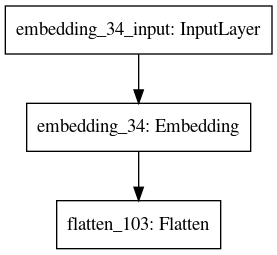

In [212]:

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
model = Sequential()
model.add(Embedding(2, 2, input_length=7))
model.compile('rmsprop', 'mse')
model.predict(np.array([[0,1,0,1,1,0,0]]))

In [ ]:
from keras.layers import Dense, Flatten, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
# define documents
docs = ['Well done!',
        'Good work',
        'Great effort',
        'nice work',
        'Excellent!',
        'Weak',
        'Poor effort!',
        'not good',
        'poor work',
        'Could have done better.']
# define class labels
labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
input = Input(shape=(4, ))
x = Embedding(vocab_size, 8, input_length=max_length)(input)
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input, outputs=x)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy * 100))

In [ ]:
input

In [ ]:
np.array([[0,1,0,1,3,0,0]])

In [ ]:
train['nom_1']